# Demo - White Attack with Imagenet

In [1]:
import numpy as np
import json
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [7]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

## 1. Load Data

In [8]:
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = torch.utils.data.DataLoader(normal_data, batch_size=1, shuffle=False)

True Image & True Label


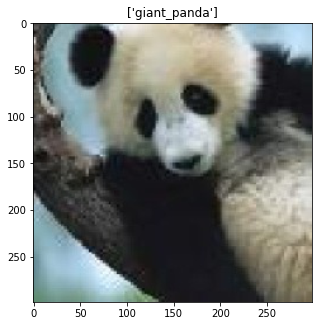

In [9]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 2. Attack Inception v3

In [10]:
model = models.inception_v3(pretrained=True).to(device)
model.eval()

fgsm_attack = torchattacks.FGSM(model, eps=0.007)
ifgsm_attack = torchattacks.IFGSM(model, eps=4/255, alpha=1/255, iters=0)
iterll_attack = torchattacks.IterLL(model, eps=4/255, alpha=1/255, iters=0)
rfgsm_attack = torchattacks.RFGSM(model, eps=16/255, alpha=8/255, iters=1)
cw_attack = torchattacks.CW(model, targeted=False, c=1, kappa=0, iters=1000, lr=0.01)
pgd_attack = torchattacks.PGD(model, eps=0.3, alpha=2/255, iters=40)

attacks = [fgsm_attack, ifgsm_attack, iterll_attack, rfgsm_attack, cw_attack, pgd_attack]

Attack Image & Predicted Label
----------------------------------------------------------------------
FGSM(mode=float, training=False, model_name=Inception3, device=cuda, eps=0.007)


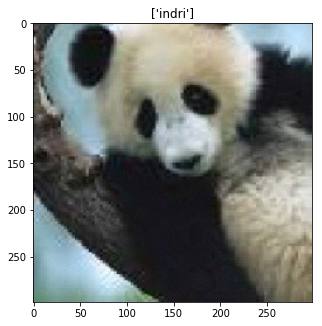

Accuracy of test text: 0.000000 %
----------------------------------------------------------------------
IFGSM(mode=float, training=False, model_name=Inception3, device=cuda, eps=0.01568627450980392, alpha=0.00392156862745098, iters=5)


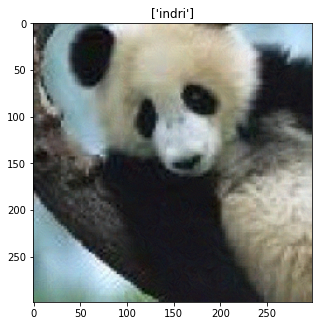

Accuracy of test text: 0.000000 %
----------------------------------------------------------------------
IterLL(mode=float, training=False, model_name=Inception3, device=cuda, eps=0.01568627450980392, alpha=0.00392156862745098, iters=5)


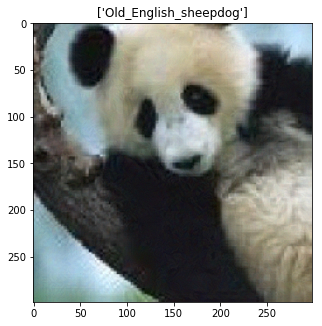

Accuracy of test text: 0.000000 %
----------------------------------------------------------------------
RFGSM(mode=float, training=False, model_name=Inception3, device=cuda, eps=0.06274509803921569, alpha=0.03137254901960784, iters=1)


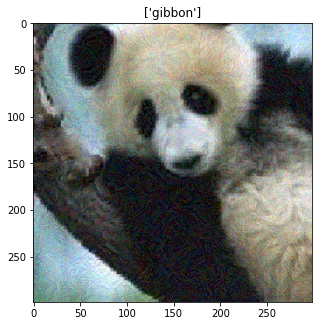

Accuracy of test text: 0.000000 %
----------------------------------------------------------------------
CW(mode=float, training=False, model_name=Inception3, device=cuda, targeted=False, c=1, kappa=0, iters=1000, lr=0.01)
CW Attack is stopped due to CONVERGENCE....


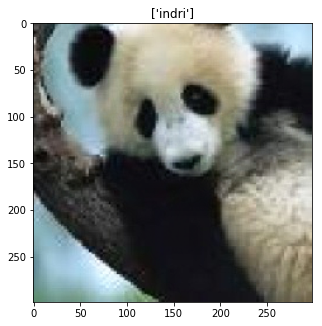

Accuracy of test text: 0.000000 %
----------------------------------------------------------------------
PGD(mode=float, training=False, model_name=Inception3, device=cuda, eps=0.3, alpha=0.00784313725490196, iters=40)


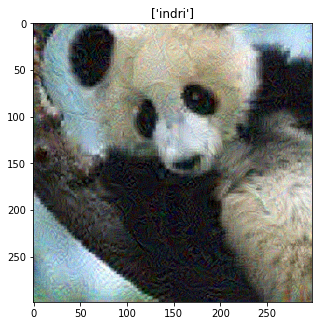

Accuracy of test text: 0.000000 %


In [11]:
print("Attack Image & Predicted Label")

for attack in attacks :
    
    print("-"*70)
    print(attack)
    
    correct = 0
    total = 0
    
    for images, labels in normal_loader:

        images = attack(images, labels)
        labels = labels.to(device)
        outputs = model(images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

    print('Accuracy of test text: %f %%' % (100 * float(correct) / total))